In [18]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def striling_approximation(n):
    return math.sqrt(2 * math.pi * n) * np.power(n / math.e, n)

f = lambda x: np.piecewise(x, [x == 0, x == 1, x > 1], [1, 1, striling_approximation(x)])

class DistributedSystem:
    def __init__(self, μ, λ, m, n, N):
        self.μ = μ
        self.λ = λ
        self.m = m
        self.N = N
    
    # delta-functor
    D = lambda self, x: np.piecewise(x, [x < 0, x >= 0], [0, 1])
    
    # pi_r(t)
    def pi_rit(self, r, i, t):
        return ((i * self.λ * t) ** r / f(r)) * math.exp(-1 * i * self.λ * t)
    
    # u_i(t)
    def u_lit(self, l, i, t):
        left_term = np.power(self.μ * t, l) / f(l)
        
        right_term = np.double(self.D(self.N - i - self.m))
        right_term *= np.power(self.m, l)
        right_term *= math.exp(-1 * i * self.μ * t)
        right_term += self.D(self.m - self.N + i)
        right_term *= np.power(self.N - i, l)
        right_term *= math.exp((i - self.N) * self.μ * t)

        return left_term * right_term

    # P_i
    def P_i(self, i):
        k = np.power(self.μ / self.λ, i) / f(i)
        acc_sum = 0
        for l in range(0, self.N + 1):
            acc_sum += np.power(self.μ / self.λ, l) / f(l)
        acc_sum = 1 / acc_sum
        return k * acc_sum
    
    # R*
    def reliability(self, n, t):
        acc_sum = 0
        for i in range(n, self.N + 1):
            acc_sum_pi = 0
            for r in range(0, i - n + 1):
                acc_sum_pi += self.pi_rit(r, i, t)
            acc_sum += acc_sum_pi * self.P_i(i)
        return acc_sum 
    
    # U*
    def recoverability(self, n, t):
        sum_p = 0
        for i in range(0, n):
            sum_pi = 0
            for l in range(0, n - i):
                sum_pi += self.u_lit(l, i, t)
            sum_p += sum_pi * self.P_i(i)
        return 1 - sum_p

    def readiness(self, n):
        if self.m == 1:
            sn = [self.P_i(j) for j in range(0, n)]
            return 1 - np.sum(sn)
        elif self.m == self.N:
            sn = np.power(self.λ, self.N - n + 1) * \
                np.power(self.λ + self.μ, n - self.N - 1)
            return 1 - sn


system_m1 = DistributedSystem(μ = 0.71, λ = 0.024, m = 1, n = 8, N = 16)
system_m16 = DistributedSystem(μ = 0.71, λ = 0.024, m = 16, n = 8, N = 16)
xn = [xi for xi in range(11, 17)]

print("Таблица коэффициента готовности S")
df = pd.DataFrame({
    'm = 1': [system_m1.readiness(xi) for xi in xn],
    'm = 16': [system_m16.readiness(xi) for xi in xn],
    }, index=xn)
df.index.name = 'n'
print(df.sort_index(ascending=False))

Таблица коэффициента готовности S
       m = 1    m = 16
n                     
16  0.490565  0.967302
15  0.755977  0.998931
14  0.890605  0.999965
13  0.954346  0.999999
12  0.982371  1.000000
11  0.993746  1.000000


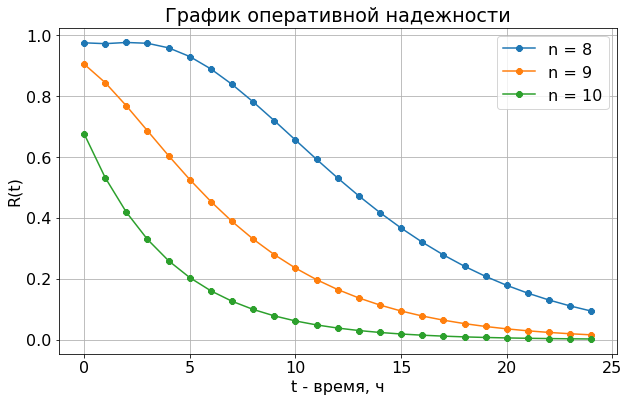

In [8]:
system_m1.N = 10
fig, ax_r = plt.subplots(figsize=(10, 6))
xn = [xi for xi in range(8, 11)]
ax_r.grid()
ax_r.set(title='График оперативной надежности', \
       xlabel='t - время, ч', \
       ylabel='R(t)')
for ni in xn:
    yn = [system_m1.reliability(ni, ti) for ti in range(0, 25, 1)]
    ax_r.plot(yn, '8-', label="n = {0}".format(ni))
    ax_r.legend()
plt.rcParams.update({'font.size': 16})
plt.show()

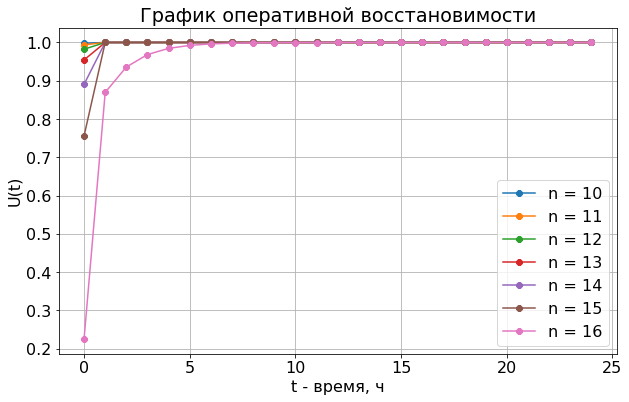

In [7]:
system_m1.N = 16
fig, ax_u = plt.subplots(figsize=(10, 6))
xn = [xi for xi in range(10, 17)]
ax_u.grid()
ax_u.set(title='График оперативной восстановимости', \
       xlabel='t - время, ч', \
       ylabel='U(t)')
for ni in xn:
    yn = [system_m1.recoverability(ni, ti) for ti in range(0, 25, 1)]
    ax_u.plot(yn, '8-', label="n = {0}".format(ni))
    ax_u.legend()
plt.show()